In [35]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import collections
import seaborn as sns
from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import operator
import os
import random

from sklearn.metrics import confusion_matrix 
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import shuffle



# EDA

### Check how many recipts, cuisine and ingredients in the dataset

In [2]:
trainrecipts = json.load(open('recipies.json','r'))

# Quick&dirty code to extract info2list
raw_ingredients = list()

for recipt in trainrecipts:
    for ingredient in recipt[u'ingredients']:
        raw_ingredients.append(ingredient.strip())      

raw_cuisines = list()
for recipt in trainrecipts:
    raw_cuisines.append(recipt[u'cuisine'].strip())

# use Counter to get frequencies 
counts_ingr = collections.Counter(raw_ingredients)
counts_cuis = collections.Counter(raw_cuisines)

# this will help us to have an idea how our corpora of 
# ingredients looks like
print('Size Ingredients dataset (with repetition):  \t{}'.format((len(raw_ingredients))))
print('Unique Ingredients dataset: \t\t\t{}'.format((len(counts_ingr.values()))))

# This will provide a distribution of cusines, indirect 
# info of the ingredients
print('Total # of recipts \t\t\t\t{}'.format(len(raw_cuisines)))
print('Total # of Cuisines \t\t\t\t{}'.format((len(counts_cuis.values()))))

Size Ingredients dataset (with repetition):  	428275
Unique Ingredients dataset: 			6714
Total # of recipts 				39774
Total # of Cuisines 				20


### Check how many recipes in each cuisine

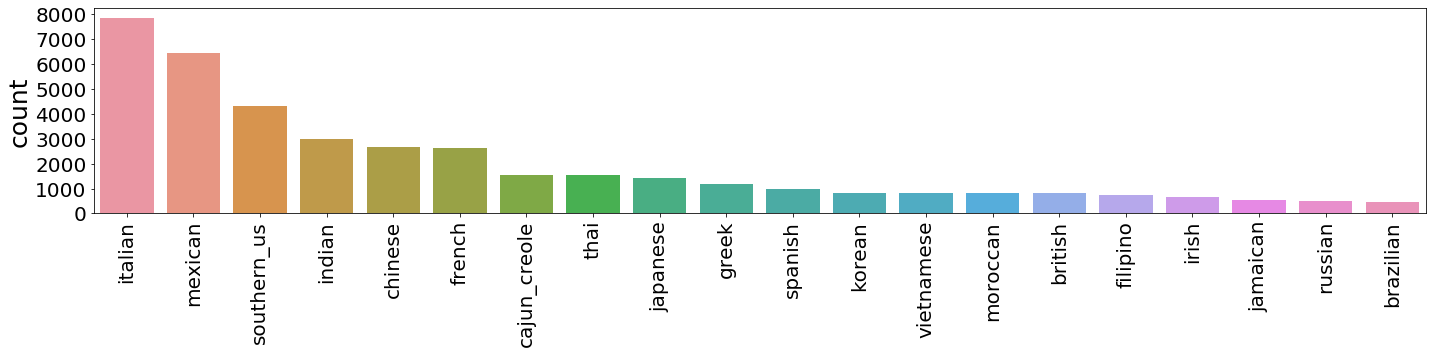

In [3]:
counts_cuis.most_common(20)
x_cu = [cu for cu, frq in counts_cuis.most_common()]
y_frq = [frq for cu, frq in counts_cuis.most_common()]

plt.figure(figsize = (20,5))
fbar = sns.barplot(x = x_cu, y = y_frq)
plt.xticks(rotation=90, fontsize = 20)                                                               
plt.yticks(fontsize = 20)
plt.ylabel('count', fontsize = 25)
plt.tight_layout()

plt.savefig('cuisines_dist.jpg')

### Check how many ingredients in one cuisine

greek    		10.18
southern_us    		9.63
filipino    		10.00
indian    		12.71
jamaican    		12.21
spanish    		10.42
italian    		9.91
mexican    		10.88
chinese    		11.98
british    		9.71
thai    		12.55
vietnamese    		12.68
cajun_creole    		12.62
brazilian    		9.52
french    		9.82
japanese    		9.74
irish    		9.30
korean    		11.28
moroccan    		12.91
russian    		10.22


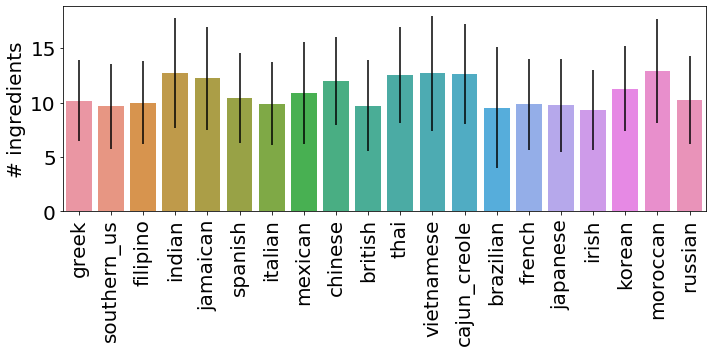

In [4]:
# init a dict with a empty list
num_ingredients = dict(zip(counts_cuis.keys(), [list() for x in counts_cuis.keys()]))
for recipt in trainrecipts:
    # append the number in the list
    num_ingredients[recipt['cuisine']].append(len(recipt['ingredients']))

len(num_ingredients)

for cu, frq in num_ingredients.items():

    print('{}    \t\t{:.2f}'.format(cu, np.mean(frq)))

x_cu = [cu for cu, frq in num_ingredients.items()]
y_frq = [np.mean(frq) for cu, frq in num_ingredients.items()]
err = [np.std(frq) for cu, frq in num_ingredients.items()]

plt.figure(figsize = (10,5))
fbar = sns.barplot(x = x_cu, y = y_frq, yerr=err)
plt.yticks(np.arange(0, 20, 5))

plt.xticks(rotation=90, fontsize = 20)                                                               
plt.yticks(fontsize = 20)
plt.ylabel('# ingredients', fontsize = 20)
plt.tight_layout()

plt.savefig('cuisines_ingre_dist.jpg')

### Check the count of the most common ingredients

63.7883526958594
388.3270259662557


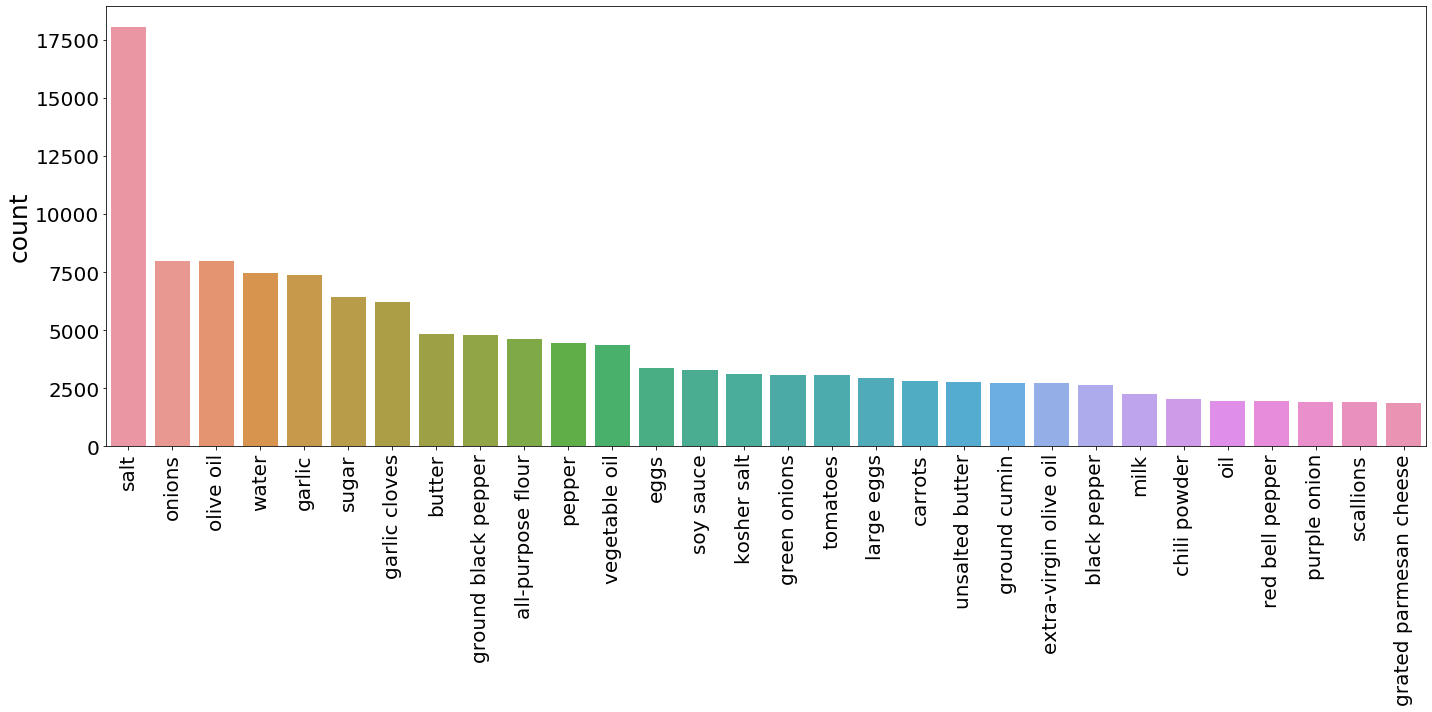

<Figure size 432x288 with 0 Axes>

In [5]:
# Dispersion of the frequencies Ingredients
print(np.mean(list(counts_ingr.values())))
print(np.std(list(counts_ingr.values())))

# top 15

x_cu = [cu for cu, frq in counts_ingr.most_common(30)]
y_frq = [frq for cu, frq in counts_ingr.most_common(30)]

plt.figure(figsize = (20,10))
fbar = sns.barplot(x = x_cu, y = y_frq)
plt.xticks(rotation=90, fontsize = 20)                                                               
plt.yticks(fontsize = 20)
plt.ylabel('count', fontsize = 25)
plt.tight_layout()
plt.show()
plt.savefig('ingre_count.jpg')

### Create word2vec model of ingredients for data clustering of cuisine using tSNE

In [10]:
## check if need to remove symbols
symbols = list()

for recipt in trainrecipts:
    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        if re.match("\(|@|\$\?", ingredient.lower()):
            symbols.append(ingredient)
print (len(symbols))
np.unique(symbols)

33


array(['(    oz.) tomato sauce', '(   oz.) tomato paste',
       '(10 oz.) frozen chopped spinach',
       '(10 oz.) frozen chopped spinach, thawed and squeezed dry',
       '(14 oz.) sweetened condensed milk', '(14.5 oz.) diced tomatoes',
       '(15 oz.) refried beans'], dtype='<U56')

In [5]:
## merge all the ingredients into sentences to generate WordtoVec model
sentences = list()
# one hot ingredients


for recipt in trainrecipts:
    clean_recipt = list()
    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        # remove this description from the ingredients
        # minimal preprocessing
        ingredient =  re.sub(r'\(.*oz.\)|crushed|crumbles|ground|minced|powder|chopped|sliced',
                             '', 
                             ingredient)
        clean_recipt.append(ingredient.strip())
    sentences.append(clean_recipt)
        
len(sentences)

39774

In [12]:
## create word2vec model
# Set values for NN parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 0                       
num_workers = 4       # Number of CPUs
context = 10          # Context window size; 
                      # let's use avg recipte size                                                                                  
downsampling = 1e-3   # threshold for configuring which 
                    # higher-frequency words are randomly downsampled

# Initialize and train the model 
model_wv = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model_wv.init_sims(replace=True)

In [13]:
## Check performance of the word2vec model
model_wv.most_similar(u'feta cheese')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('kalamata', 0.9493091106414795),
 ('fresh oregano', 0.9177654385566711),
 ('pitted kalamata olives', 0.9168459177017212),
 ('greek seasoning', 0.8984208106994629),
 ('roasted red peppers', 0.8977060317993164),
 ('olives', 0.8973791003227234),
 ('pita bread rounds', 0.8933000564575195),
 ('tzatziki', 0.8854813575744629),
 ('grape tomatoes', 0.8810263872146606),
 ('plum tomatoes', 0.8750413060188293)]

In [14]:
corpus = sorted(model_wv.wv.vocab.keys()) 
emb_tuple = tuple([model_wv[v] for v in corpus])
X = np.vstack(emb_tuple)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [15]:
model_wv.wv.save_word2vec_format('ingredients_embedding.txt', binary = False)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [16]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [18]:
track_ingredients = dict(zip(counts_cuis.keys(), [list() for x in counts_cuis.keys()]))
for recipt in trainrecipts:
    # append the number in the list
    clean_recipt = list()
    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        # remove this description from the ingredients
        # (10 oz.) 
        ingredient =  re.sub(r'crushed|crumbles|ground|minced|powder|chopped|sliced', '', ingredient)
        clean_recipt.append(ingredient.strip())
        
    track_ingredients[recipt['cuisine']].extend(clean_recipt)

for label, tracking in track_ingredients.items():
    track_ingredients[label] = collections.Counter(tracking)

In [47]:
for key in track_ingredients:
    print (key, 'food has common ingredients of:')
    sorted_values = sorted(track_ingredients[key].items(), key=operator.itemgetter(1))
    print(sorted_values[-10:])
    print('')



greek food has common ingredients of:
[('fresh lemon juice', 222), ('pepper', 224), ('extra-virgin olive oil', 229), ('garlic cloves', 254), ('dried oregano', 267), ('black pepper', 310), ('garlic', 330), ('feta cheese', 443), ('olive oil', 504), ('salt', 572)]

southern_us food has common ingredients of:
[('milk', 645), ('unsalted butter', 655), ('water', 686), ('baking', 729), ('black pepper', 736), ('large eggs', 746), ('sugar', 1054), ('all-purpose flour', 1222), ('butter', 1255), ('salt', 2290)]

filipino food has common ingredients of:
[('carrots', 128), ('sugar', 136), ('black pepper', 153), ('oil', 166), ('pepper', 209), ('soy sauce', 251), ('water', 310), ('onions', 310), ('garlic', 394), ('salt', 421)]

indian food has common ingredients of:
[('ginger', 694), ('cumin seed', 697), ('turmeric', 728), ('water', 820), ('coriander', 820), ('cumin', 861), ('garam masala', 862), ('garlic', 894), ('onions', 1195), ('salt', 1934)]

jamaican food has common ingredients of:
[('dried thy

In [48]:
def return_most_popular(v):
    cuisine = None
    record = 0
    for label, tracking in track_ingredients.items():
        norm_freq = float(tracking[v]) / float(counts_cuis[label])
        if norm_freq > record:
            cuisine = label
            record = norm_freq
    return cuisine

In [49]:
track_2color = {u'irish':"#000000", # blak
                u'mexican':"#FFFF00", #yellow
                u'chinese':"#1CE6FF", #cyan
                u'filipino': "#FF34FF", #pink 
                u'vietnamese':"#FF4A46", #red
                u'spanish':"#FFC300",  # green forest
                u'japanese':"#006FA6", # blue ocean
                u'moroccan':"#A30059",# purple
                u'french':"#FFDBE5",  #light pink
                u'greek': "#7A4900",  # gold or brown 
                u'indian':"#0000A6", # blue electric 
                u'jamaican':"#63FFAC", # green phospho
                u'british': "#B79762", #brown
                u'brazilian': "#EEC3FF", #  
                u'russian':"#8FB0FF", # light blue 
                u'cajun_creole':"#997D87", #violet
                u'thai':"#5A0007", 
                u'southern_us':"#809693", 
                u'korean':"#FEFFE6", #ligt yellow
                u'italian':"#1B4400"}

color_vector = list()
for v in corpus:
    cuisine = return_most_popular(v)
    color_vector.append(track_2color[cuisine])


In [50]:
# ensemble the legend
lgend = list()
for l, c in track_2color.items():
    lgend.append(mpatches.Patch(color=c, label=l))

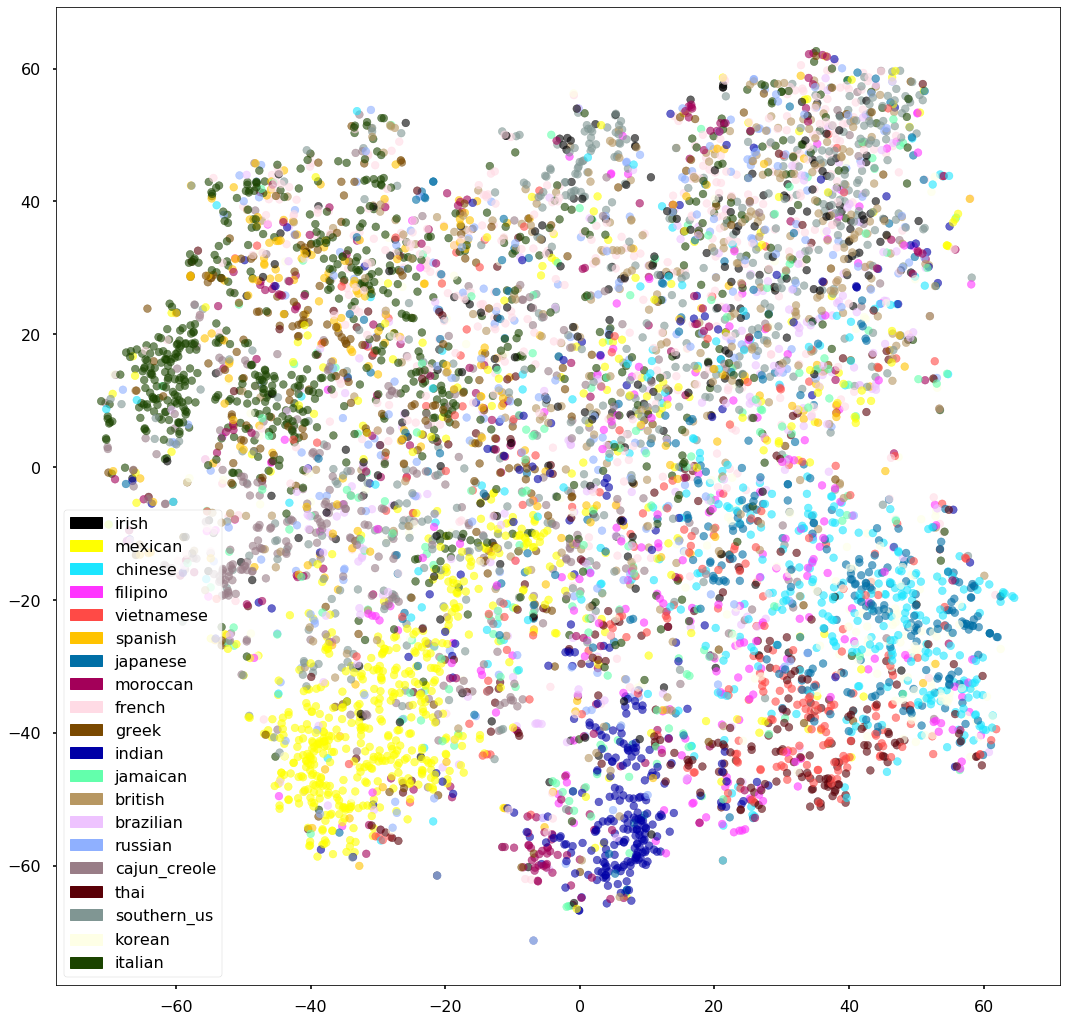

In [53]:
sns.set_context("poster")
fig, ax = plt.subplots(figsize=(18,18))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color_vector, alpha=.6, s=60)
plt.legend(handles=lgend)
plt.savefig('tSNE')

# Build LSTM model for classification

## Prepare data

In [80]:
X = sentences
max_length = max([len(s) for s in X])
# maximum length of a number of ingredients

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(X)

X_token = tokenizer_obj.texts_to_sequences(X)
X_pad = pad_sequences(X_token, maxlen = max_length, padding = 'post')

In [81]:
y = raw_cuisines
np.shape(y)
le = LabelEncoder()
le.fit(y)

y_cat = le.transform(y) # convert y (cuisine to categorical data)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, test_size=0.33, random_state=42)


## Model development

Load the word2vec embedding that we produced earlier and use it as our embedding layer

In [85]:
embeddings_index = {}
f = open(os.path.join('','ingredients_embedding.txt'), encoding = 'utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
    
f.close()

word_index = tokenizer_obj.word_index
num_words = len(word_index) + 1

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector[-EMBEDDING_DIM:]    

Use GRU

In [88]:
model_wv_seq = Sequential()
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)
model_wv_seq.add(embedding_layer)
# model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length = max_length))
model_wv_seq.add(GRU(units = 32, dropout = 0.2, recurrent_dropout = 0.2))
model_wv_seq.add(Dense(n_cuisines, activation = 'softmax'))
model_wv_seq.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_wv_seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 65, 300)           1961400   
_________________________________________________________________
gru_5 (GRU)                  (None, 32)                31968     
_________________________________________________________________
dense_5 (Dense)              (None, 20)                660       
Total params: 1,994,028
Trainable params: 32,628
Non-trainable params: 1,961,400
_________________________________________________________________


In [89]:
model_wv_seq.fit(X_train, y_train, batch_size = 128, epochs = 5, validation_data = (X_test, y_test))

Train on 26648 samples, validate on 13126 samples
Epoch 1/5
26648/26648 [==============================] - 25s 953us/step - loss: 2.6863 - acc: 0.1961 - val_loss: 2.6054 - val_acc: 0.1966
Epoch 2/5
26648/26648 [==============================] - 24s 910us/step - loss: 2.5717 - acc: 0.2304 - val_loss: 2.4711 - val_acc: 0.2769
Epoch 3/5
26648/26648 [==============================] - 24s 908us/step - loss: 2.3968 - acc: 0.3021 - val_loss: 2.3019 - val_acc: 0.3236
Epoch 4/5
26648/26648 [==============================] - 24s 907us/step - loss: 2.2845 - acc: 0.3287 - val_loss: 2.1898 - val_acc: 0.3578
Epoch 5/5
26648/26648 [==============================] - 24s 907us/step - loss: 2.1887 - acc: 0.3538 - val_loss: 2.1131 - val_acc: 0.3758


Accuracy not high may be because the order in the ingredients (one appear before another doesn't matter), use bidirectional network instead

Use bidirectional GRU

In [90]:
model_wv_seq_bi = Sequential()
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)
model_wv_seq_bi.add(embedding_layer)
# model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length = max_length))
model_wv_seq_bi.add(Bidirectional(GRU(units = 32, dropout = 0.2, recurrent_dropout = 0.2)))
model_wv_seq_bi.add(Dense(n_cuisines, activation = 'softmax'))
model_wv_seq_bi.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_wv_seq_bi.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 65, 300)           1961400   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                63936     
_________________________________________________________________
dense_6 (Dense)              (None, 20)                1300      
Total params: 2,026,636
Trainable params: 65,236
Non-trainable params: 1,961,400
_________________________________________________________________


In [91]:
model_wv_seq_bi.fit(X_train, y_train, batch_size = 128, epochs = 5, validation_data = (X_test, y_test))

Train on 26648 samples, validate on 13126 samples
Epoch 1/5
26648/26648 [==============================] - 46s 2ms/step - loss: 2.5352 - acc: 0.2616 - val_loss: 2.2834 - val_acc: 0.3338
Epoch 2/5
26648/26648 [==============================] - 44s 2ms/step - loss: 2.2112 - acc: 0.3564 - val_loss: 2.1057 - val_acc: 0.3867
Epoch 3/5
26648/26648 [==============================] - 44s 2ms/step - loss: 2.1127 - acc: 0.3821 - val_loss: 2.0422 - val_acc: 0.4042
Epoch 4/5
26648/26648 [==============================] - 44s 2ms/step - loss: 2.0646 - acc: 0.3973 - val_loss: 2.0013 - val_acc: 0.4141
Epoch 5/5
26648/26648 [==============================] - 44s 2ms/step - loss: 2.0261 - acc: 0.4076 - val_loss: 1.9613 - val_acc: 0.4232


### Accuracy improved  from 0.35 to 0.40

Use bidirectional LSTM 

In [92]:
model_wv_seq_bi_LSTM = Sequential()
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)
model_wv_seq_bi_LSTM.add(embedding_layer)
# model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length = max_length))
model_wv_seq_bi_LSTM.add(Bidirectional(LSTM(units = 32, dropout = 0.2, recurrent_dropout = 0.2)))
model_wv_seq_bi_LSTM.add(Dense(n_cuisines, activation = 'softmax'))
model_wv_seq_bi_LSTM.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_wv_seq_bi.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 65, 300)           1961400   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                63936     
_________________________________________________________________
dense_6 (Dense)              (None, 20)                1300      
Total params: 2,026,636
Trainable params: 65,236
Non-trainable params: 1,961,400
_________________________________________________________________


In [93]:
model_wv_seq_bi_LSTM.fit(X_train, y_train, batch_size = 128, epochs = 5, validation_data = (X_test, y_test))

Train on 26648 samples, validate on 13126 samples
Epoch 1/5
26648/26648 [==============================] - 56s 2ms/step - loss: 2.4926 - acc: 0.2796 - val_loss: 2.2360 - val_acc: 0.3531
Epoch 2/5
26648/26648 [==============================] - 53s 2ms/step - loss: 2.1920 - acc: 0.3628 - val_loss: 2.1068 - val_acc: 0.3880
Epoch 3/5
26648/26648 [==============================] - 53s 2ms/step - loss: 2.1103 - acc: 0.3809 - val_loss: 2.0322 - val_acc: 0.3966
Epoch 4/5
26648/26648 [==============================] - 53s 2ms/step - loss: 2.0500 - acc: 0.3967 - val_loss: 1.9871 - val_acc: 0.4128
Epoch 5/5
26648/26648 [==============================] - 53s 2ms/step - loss: 2.0048 - acc: 0.4096 - val_loss: 1.9534 - val_acc: 0.4237


### Accuracy didn't change dramactially

## Method 2: train my own embedding layer

In [118]:
n_cuisines = 20
EMBEDDING_DIM = 300
vocab_size = 6714

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length = max_length))
model.add(Bidirectional(GRU(units = 32, dropout = 0.2, recurrent_dropout = 0.2)))
model.add(Dense(n_cuisines, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(X_train, y_train, batch_size = 128, epochs = 50, \
                    validation_data = (X_test, y_test),
                    callbacks=[es, mc])
# note that the model has trained for 5 epoches previously

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 65, 300)           2014200   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 64)                63936     
_________________________________________________________________
dense_14 (Dense)             (None, 20)                1300      
Total params: 2,079,436
Trainable params: 2,079,436
Non-trainable params: 0
_________________________________________________________________
Train on 26648 samples, validate on 13126 samples
Epoch 1/50
26648/26648 [==============================] - 52s 2ms/step - loss: 1.9572 - acc: 0.4420 - val_loss: 1.4128 - val_acc: 0.5821
Epoch 2/50
26648/26648 [==============================] - 48s 2ms/step - loss: 1.2105 - acc: 0.6413 - val_loss: 1.0913 - val_acc: 0.6790
Epoch 3/50
26648/26648 [==============================] - 48s 2ms/step -

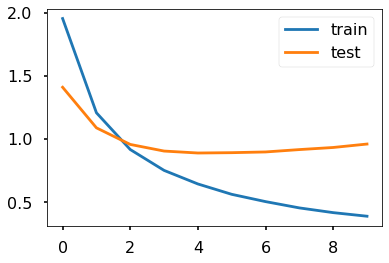

In [123]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

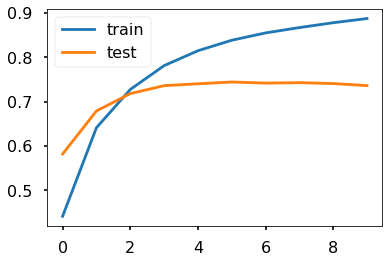

In [125]:
# plot training history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [128]:
model.load_weights('best_model.hdf5')

In [126]:
def predict_model_index(i, le, y_test, model):
    results = model.predict(np.expand_dims(X_test[i],axis = 0))
    results = np.argmax(results)
    results = le.inverse_transform([results])
    print('predict cusine is', results, 'while real cusine is',le.inverse_transform([y_test[i]]))

In [129]:
for i in range (10):
    predict_model_index(i, le, y_test, model)

predict cusine is ['chinese'] while real cusine is ['chinese']
predict cusine is ['mexican'] while real cusine is ['spanish']
predict cusine is ['greek'] while real cusine is ['greek']
predict cusine is ['indian'] while real cusine is ['indian']
predict cusine is ['mexican'] while real cusine is ['italian']
predict cusine is ['mexican'] while real cusine is ['mexican']
predict cusine is ['italian'] while real cusine is ['italian']
predict cusine is ['cajun_creole'] while real cusine is ['cajun_creole']
predict cusine is ['greek'] while real cusine is ['greek']
predict cusine is ['mexican'] while real cusine is ['mexican']


In [130]:
y_pred = model.predict(X_test, verbose = 1)
y_pred_max = np.argmax(y_pred,axis = 1)

13126/13126 [==============================] - 30s 2ms/step


In [38]:
labels = le.classes_ # get label names for the confusion matrix

In [39]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize = (20,20))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Normalized confusion matrix
[[4.20731707e-01 6.09756098e-03 4.26829268e-02 1.82926829e-02
  1.21951220e-02 2.43902439e-02 0.00000000e+00 1.21951220e-02
  6.09756098e-03 2.43902439e-02 5.48780488e-02 1.21951220e-02
  0.00000000e+00 1.64634146e-01 1.82926829e-02 0.00000000e+00
  1.15853659e-01 4.26829268e-02 1.82926829e-02 6.09756098e-03]
 [0.00000000e+00 2.76752768e-01 1.10701107e-02 7.38007380e-03
  1.10701107e-02 2.76752768e-01 0.00000000e+00 1.84501845e-02
  1.43911439e-01 7.74907749e-02 7.38007380e-03 3.69003690e-03
  0.00000000e+00 3.69003690e-03 0.00000000e+00 7.38007380e-03
  1.54981550e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.88679245e-03 3.77358491e-03 6.92452830e-01 1.88679245e-03
  3.77358491e-03 4.15094340e-02 1.88679245e-03 3.77358491e-03
  1.88679245e-03 4.90566038e-02 9.43396226e-03 0.00000000e+00
  0.00000000e+00 3.77358491e-02 3.77358491e-03 0.00000000e+00
  1.39622642e-01 7.54716981e-03 0.00000000e+00 0.00000000e+00]
 [2.39520958e-03 1.19760479e-03 1.19760

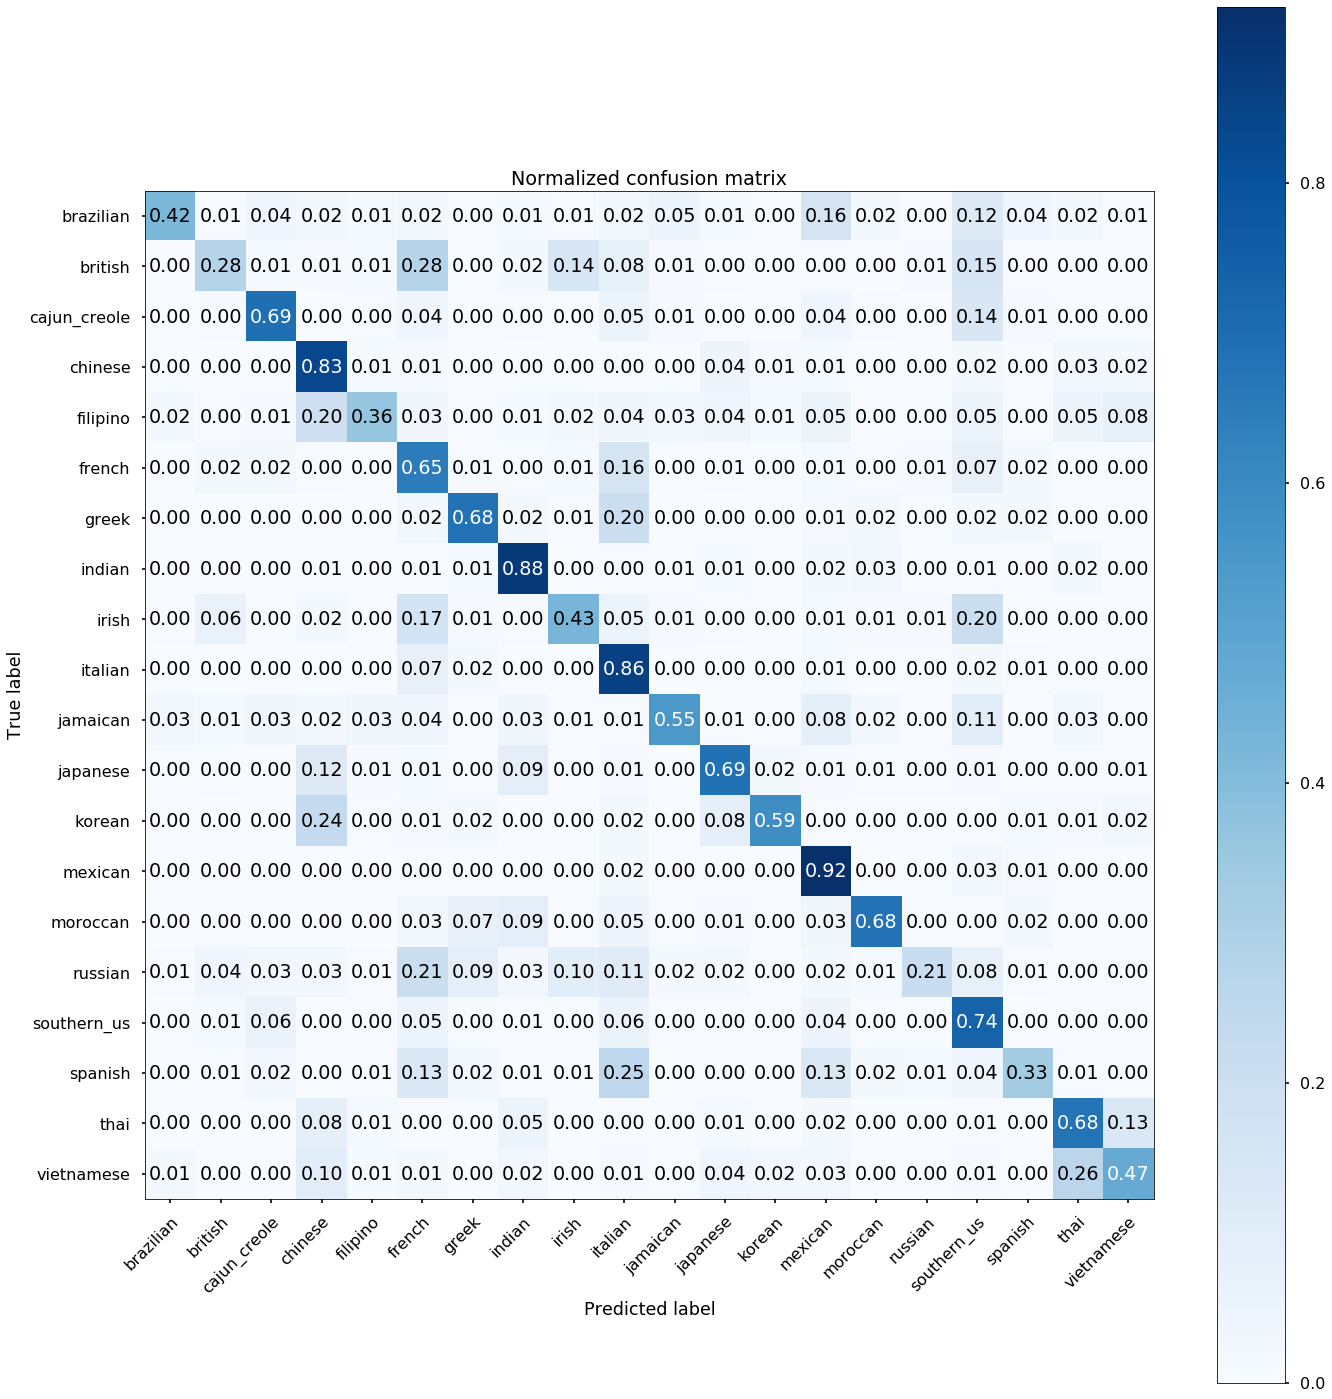

In [133]:
# Plot normalized confusion matrix

plot_confusion_matrix(y_test, y_pred_max, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


Bad performance class: brazilian, british, filipino, irish, jamaican, russian, spanish, vietnamese are also minority classes, should do data augumentation

### Data augmentation for the minority class

In [91]:
def shuffle_whole_class(tokens_class, n):
    shuffled =[]
    
    for i in range(len(tokens_class)):
        for j in range(n):
            new_tokens = random.sample(tokens_class[i], len(tokens_class[i]))
            shuffled.append(new_tokens)
    
    return(shuffled)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_token, raw_cuisines, test_size=0.33, random_state=42)


X_test = pad_sequences(X_test, maxlen = max_length, padding = 'post')
y_test = le.transform(y_test)

new_x = np.asarray(X_train)
new_y = np.asarray(y_train)

In [88]:
chosen_index = np.where(new_y =='brazilian')

In [89]:
chosen_x = new_x[chosen_index]
print (np.shape(chosen_x))

(303,)


In [93]:
extend_x = shuffle_whole_class(chosen_x, 10)
extend_x = pad_sequences(extend_x, maxlen = max_length, padding = 'post')
np.shape(extend_x)

In [98]:
extend_y = ['brazilian']*len(extend_x)

In [100]:
X_train = pad_sequences(X_train, maxlen = max_length, padding = 'post')
new_trainX = np.vstack((X_train, extend_x))

np.shape(new_trainX)

In [103]:
new_trainX, new_trainy = shuffle(new_trainX, new_trainy, random_state=0)
new_trainX = np.asarray(new_trainX)

new_trainy = np.hstack((y_train, extend_y))
new_trainy = np.asarray(new_trainy)
new_trainy = le.transform(new_trainy) # convert y (cuisine to categorical data)

(3030,)

In [115]:
n_cuisines = 20
EMBEDDING_DIM = 300
vocab_size = 6714

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length = max_length))
model.add(Bidirectional(GRU(units = 32, dropout = 0.2, recurrent_dropout = 0.2)))
model.add(Dense(n_cuisines, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', mode='min', save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 65, 300)           2014200   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                63936     
_________________________________________________________________
dense_6 (Dense)              (None, 20)                1300      
Total params: 2,079,436
Trainable params: 2,079,436
Non-trainable params: 0
_________________________________________________________________


In [119]:
history = model.fit(new_trainX, new_trainy, batch_size = 128, epochs = 50, \
                    validation_data = (X_test, y_test),
                    callbacks=[es, mc])

Train on 29678 samples, validate on 13126 samples
Epoch 1/50
29678/29678 [==============================] - 54s 2ms/step - loss: 1.8698 - acc: 0.4632 - val_loss: 1.2981 - val_acc: 0.6191
Epoch 2/50
29678/29678 [==============================] - 52s 2ms/step - loss: 1.0393 - acc: 0.6996 - val_loss: 1.0399 - val_acc: 0.6938
Epoch 3/50
29678/29678 [==============================] - 51s 2ms/step - loss: 0.8051 - acc: 0.7651 - val_loss: 0.9519 - val_acc: 0.7214
Epoch 4/50
29678/29678 [==============================] - 51s 2ms/step - loss: 0.6724 - acc: 0.8060 - val_loss: 0.9191 - val_acc: 0.7308
Epoch 5/50
29678/29678 [==============================] - 51s 2ms/step - loss: 0.5798 - acc: 0.8321 - val_loss: 0.9113 - val_acc: 0.7385
Epoch 6/50
29678/29678 [==============================] - 51s 2ms/step - loss: 0.5152 - acc: 0.8484 - val_loss: 0.9177 - val_acc: 0.7385
Epoch 7/50
29678/29678 [==============================] - 51s 2ms/step - loss: 0.4654 - acc: 0.8651 - val_loss: 0.9338 - val_acc

In [120]:
y_pred = model.predict(X_test, verbose = 1)
y_pred_max = np.argmax(y_pred,axis = 1)

13126/13126 [==============================] - 30s 2ms/step


Normalized confusion matrix
[[6.89024390e-01 6.09756098e-03 6.09756098e-03 1.21951220e-02
  6.09756098e-03 1.21951220e-02 6.09756098e-03 1.21951220e-02
  1.21951220e-02 6.09756098e-03 2.43902439e-02 0.00000000e+00
  0.00000000e+00 9.14634146e-02 6.09756098e-03 6.09756098e-03
  6.70731707e-02 2.43902439e-02 1.21951220e-02 0.00000000e+00]
 [7.38007380e-03 3.98523985e-01 3.69003690e-03 7.38007380e-03
  0.00000000e+00 1.25461255e-01 1.84501845e-02 4.42804428e-02
  1.07011070e-01 8.11808118e-02 3.69003690e-03 3.69003690e-03
  0.00000000e+00 1.47601476e-02 7.38007380e-03 2.95202952e-02
  1.40221402e-01 7.38007380e-03 0.00000000e+00 0.00000000e+00]
 [1.13207547e-02 7.54716981e-03 6.09433962e-01 1.88679245e-03
  5.66037736e-03 2.07547170e-02 3.77358491e-03 0.00000000e+00
  0.00000000e+00 5.28301887e-02 5.66037736e-03 0.00000000e+00
  0.00000000e+00 4.90566038e-02 7.54716981e-03 1.13207547e-02
  1.98113208e-01 1.50943396e-02 0.00000000e+00 0.00000000e+00]
 [1.19760479e-03 1.19760479e-03 1.19760

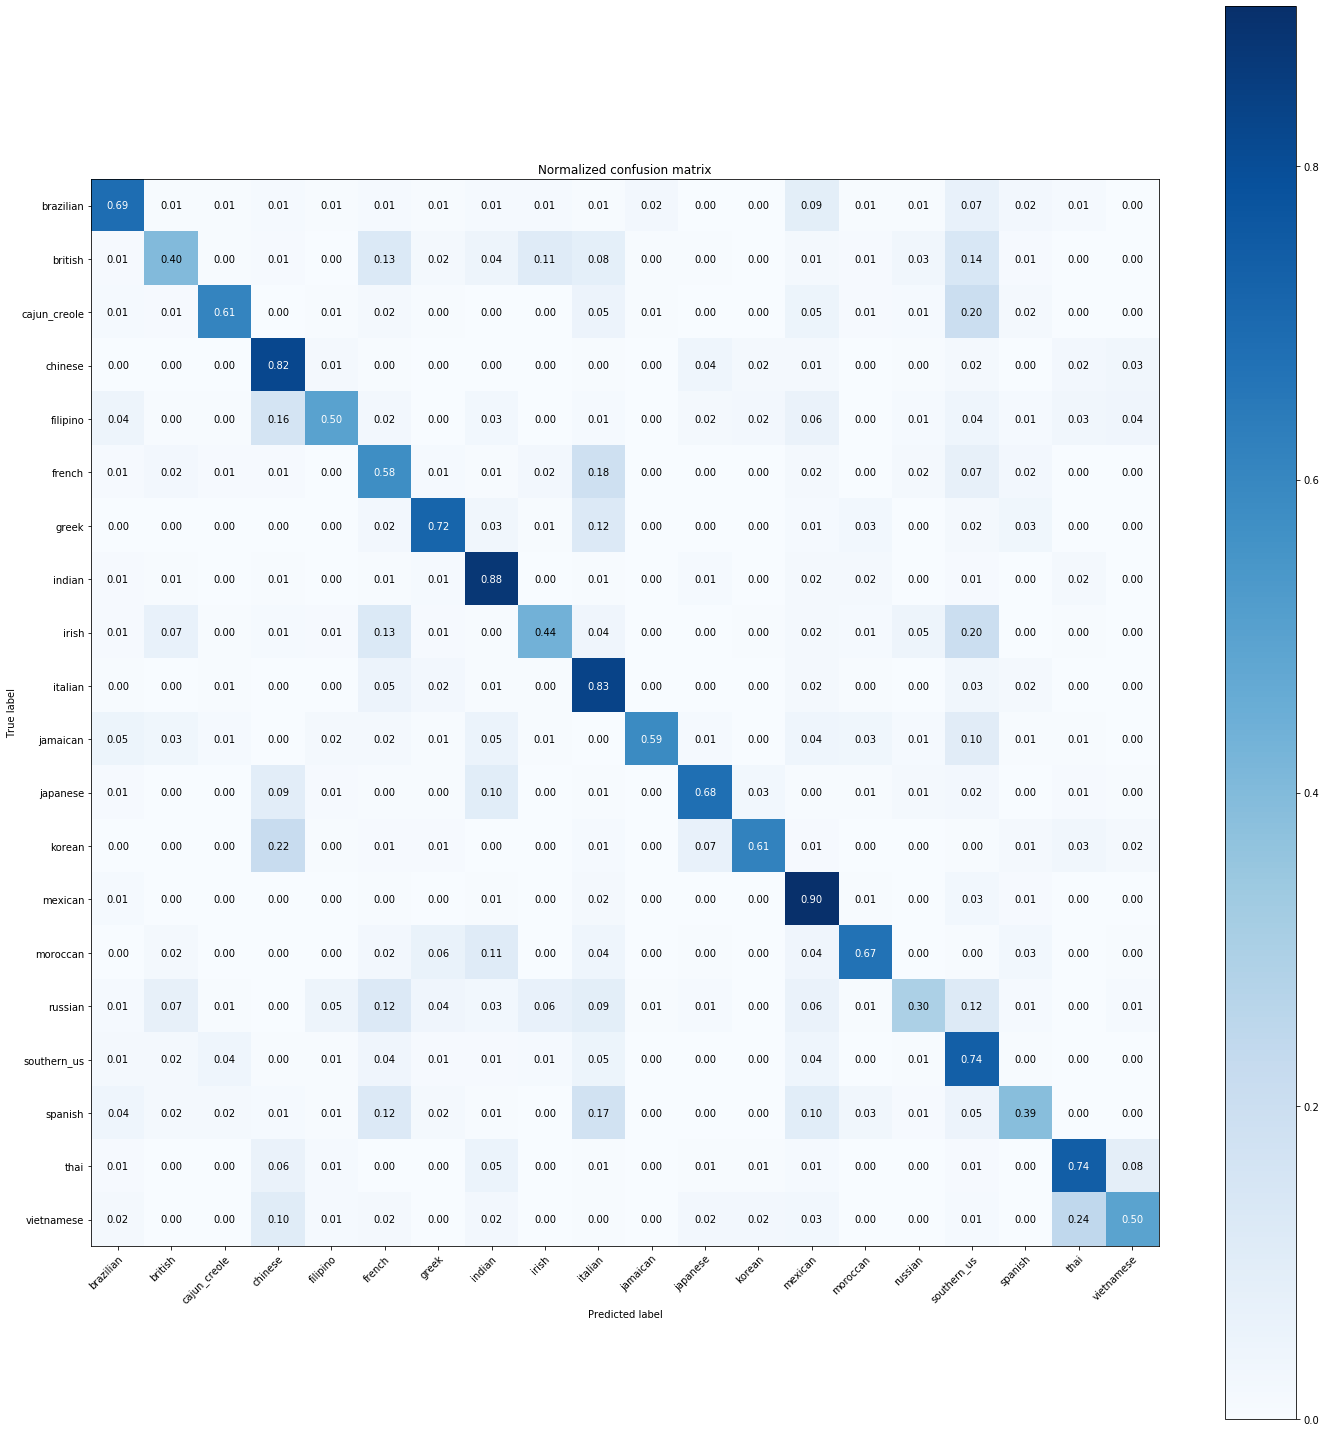

In [121]:
# Plot normalized confusion matrix

plot_confusion_matrix(y_test, y_pred_max, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()